# Identifying Need for Change: North Carolina School Performance

Out of the 2,617 public schools (including Charter) operating in North Carolina during the 2016-2017 school year, 902 schools (34.5%) have, for at least one year since 2013-2014, been classified as a low performing school. 

NCPDI classifies low performing schools as:

“Low-performing schools are those that receive a **school performance grade** of **D** or **F** and a **school growth score** of **"met expected growth"** or **"not met expected growth"** as defined by G.S. 115C-83.15.” (G.S. 115C-105.37(a)), and

“A Low-performing local school administrative unit is a unit in which the majority of the schools in that unit that received a school performance grade and school growth score as provided in G.S. 115C-83.15 have been identified as low-performing schools, as provided in G.S. 115C-105.37.” (G.S. 115C-105.39A(a)).

Source: http://www.ncpublicschools.org/schooltransformation/low-performing/

**Thus, we treat low performing schools as a proxy for aggregate student educational achievement.**


## Problem Statement: 
In recent years, 30% of public schools in North Carolina have been low performing. Students in low performing schools are not meeting the educational achievement standards set by the state. Factors outside administrators' control: economically disadvantaged and majority-minority student populations, are the most influential indicators of low performance.  


## Motivation: 
Of the 902 schools low performing between 2013/14 and 2016/17, 209 have been low performing for all schools years (8%), 203 have been low performing for 3 of the schools years (7.8%), 227 have been low performing for 2 schools years (8.7%), and 263 have been low performing once (10%). Another way to look at these numbers is to consider that out of the four school years between 2013/14 and 2016/2017, 24.4% of schools have been recurringly low performing. 

What does this mean in terms of students? 
Out of around the 1.5 million total number of students studying in a public school in the 2016/17 school year, around 460,000 of those students (30%) have had at least a year studying a low performing school. Around 100,000 students (6.8%) in North Carolina study at a school that has been low performing for 4 years. 


## Solution:
We identify the factors within school administrator's control that can positively impact a school's EVAAS growth score. Growth scores are a metric to measure how well a school's performance increases over a year. We focus on growth instead of raw performance scores, as raw scores will be much slower to change over time. 

This notebook reviews NCPDI North Carolina School Report Card and Statistical Profile data to identify the factors that contribute to low school performance and EVAAS growth scores. We will then create a model to predict EVAAS growth scores including only school-level factors irrespective of student demographics. After determining the most predictive factors for determining EVAAS growth scores, we simulate changes in these factors to demonstrate a theoretical improvement in student achievement growth. 

We: 
1. Take a look at the heuristically most common reasons for low school performance: percentage of economically disadvantaged students, student demographics, and school funding to see if these indicators are statistically different in low performing schools. 

2. **Remove the factors outside of the school adminsitration's control from the dataset to determine which school-level factors are most important in determining low performance by: Performing Feature Importance using XGBoost. XGBoost is a tree-based gradient-boosting method which minimizes a cost function relative to predicting a target variable. When a node in a decision tree is split, we can calculate the following reduction in impurity, and attribute this reduction to feature involved. When the tree is finished splitting nodes, those features with the largest proportional contribution toward decreasing impurity within nodes can be said to be the most “important.”**
    
4. Test the predictive nature of our selected features by creating a classification model to predict the EVAAS growth score for each of our 4 years. Whether these features are important will be reflected in the accuracy and precision of the regression model. 

5. Use a new methodology for decision-making. We create a function that will synthesize data based on percent changes in a certain input feature to then be used in our regression model to predict low performance. This will allow us to review, all things being equal, how a change in one or more features may correlate to a change in school EVAAS growth score. 


*Please note: Dataset Creation and Processing can be found: https://github.com/oleeson/NCPDI-Capstone*

# FINDINGS
# Top Features of Importance for EVAAS GROWTH SCORE Prediction

### School and Environment Level 
#### Resources
- student_num: Number of students at school level (school size) 

- class_teach_num: Average number of classroom teachers at School Level 
- lea_class_teach_num: Average number of classroom teachers at LEA Level 

- wap_num: Wireless Access Points at the school level
- wap_per_classroom: Wireless Access Points per Classroom at the school level

- stud_internet_comp_num: Ratio of students to internet connected computer at school level 
- lea_stud_internet_comp_num: Ratio of students to internet connected computer at LEA level 

- summer_program_ind: Summer school program was included in Read to Achieve results


#### Discipline
- avg_daily_attend_pct: Average daily attendance percentage at school level
- lea_avg_daily_attend_pct: Average daily attendance percentage at LEA level

- short_susp_per_c_num: Short term suspensions per 100 students at school level 
- lea_short_susp_per_c_num: Short term suspensions per 100 students at LEA level 

- lea_crime_per_c_num: Number of crimes or acts of violence per 100 students at LEA level 
- crime_per_c_num: Number of crimes or acts of violence per 100 students at school level 

### Educator Level
#### Teachers
- flicensed_teach_pct: Percent of teachers that meet NC fully licensed definition at school level
- nbpts_num: Number of National Board Certified Staff at school level 

- tchyrs_0thru3_pct: Percent of teachers with 0 - 3 years of experience at the school level
- tchyrs_4thru10_pct: Percent of teachers with 4 - 10 years of experience at the school level
- lea_tchyrs_4thru10_pct: Percent of teachers with 4 - 10 years of experience at the LEA level

- advance_dgr_pct: Percent of teachers with masters or higher degree at school level 
- lea_advance_dgr_pct: Percent of teachers with masters or higher degree at LEA level  

- Accomplished_TCHR_Standard 1_Pct : Percent of Teachers reaching standard 1 : Teachers Demonstrate Leadership

#### Principals
- 10+ Years_LEA_Exp_Pct_Prin : Percent of principals with 10+ years of experience at the LEA level

In [1]:
#import required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings("ignore")

#Change Dir to Import Dataset for EDA 
os.chdir("..")
cwd = os.getcwd()
cwd = cwd + "/DatasetCreation"

In [2]:
## Read in Schools Dataset
df_14 = pd.read_csv(cwd+'/2014/PublicSchools2014_LPS_Processed.csv')
df_15 = pd.read_csv(cwd+'/2015/PublicSchools2015_LPS_Processed.csv')
df_16 = pd.read_csv(cwd+'/2016/PublicSchools2016_LPS_Processed.csv')
df_17 = pd.read_csv(cwd+'/2017/PublicSchools2017_LPS_Processed.csv')

In [3]:
#list(df_17.columns)

In [4]:
#Create Column Subsets
profileCols = ['title1_type_cd',
 'clp_ind',
 'focus_clp_ind',
 'summer_program_ind',
 'asm_no_spg_ind',
 'no_data_spg_ind',
 'student_num',
 'lea_avg_student_num',
 'Grad_project_status', 
 'category_cd_E',
 'category_cd_H',
 'category_cd_I',
 'category_cd_M',
 'category_cd_T',
 'esea_status_Esea_Pass',
 'esea_status_Non_Esea',
 'SBE District_Northeast',
 'SBE District_Northwest',
 'SBE District_Piedmont-Triad',
 'SBE District_Sandhills',
 'SBE District_Southeast',
 'SBE District_Southwest',
 'SBE District_Western']

demographicCols = ['AsianFemalePct',
 'AsianMalePct',
 'AsianPct',
 'BlackFemalePct',
 'BlackMalePct',
 'BlackPct',
 'HispanicFemalePct',
 'HispanicMalePct',
 'HispanicPct',
 'IndianFemalePct',
 'IndianMalePct',
 'IndianPct',
 'MinorityFemalePct',
 'MinorityMalePct',
 'MinorityPct',
 'PacificIslandFemalePct',
 'PacificIslandMalePct',
 'PacificIslandPct',
 'TwoOrMoreFemalePct',
 'TwoOrMoreMalePct',
 'TwoOrMorePct',
 'WhiteFemalePct',
 'WhiteMalePct',
 'WhitePct',
 'pct_eds']

environmentCols = ['avg_daily_attend_pct',
 'crime_per_c_num',
 'short_susp_per_c_num',
 'long_susp_per_c_num',
 'expelled_per_c_num',
 'stud_internet_comp_num',
 'lea_avg_daily_attend_pct',
 'lea_crime_per_c_num',
 'lea_short_susp_per_c_num',
 'lea_long_susp_per_c_num',
 'lea_expelled_per_c_num',
 'lea_stud_internet_comp_num',
 'digital_media_pct',
 'avg_age_media_collection',
 'books_per_student',
 'lea_avg_age_media_collection',
 'lea_books_per_student',
 'wap_num',
 'wap_per_classroom',
 'lea_wap_num',
 'lea_wap_per_classroom',
 'Byod_Yes',
 '_1_to_1_access_Yes',
 'SRC_devices_sent_home_Yes']

educatorCols = ['flicensed_teach_pct',
 'tchyrs_0thru3_pct',
 'tchyrs_4thru10_pct',
 'tchyrs_11plus_pct',
 'class_teach_num',
 'nbpts_num',
 'advance_dgr_pct',
 '_1yr_tchr_trnovr_pct',
 'lea_flicensed_teach_pct',
 'lea_tchyrs_0thru3_pct',
 'lea_tchyrs_4thru10_pct',
 'lea_tchyrs_11plus_pct',
 'lea_class_teach_num',
 'lea_nbpts_num',
 'lea_advance_dgr_pct',
 'lea_1yr_tchr_trnovr_pct',
 'lea_lateral_teach_pct',
 '0-3 Years_Exp_Pct_Tch',
 '10+ Years_Exp_Pct_Tch',
 '4-10 Years_Exp_Pct_Tch',
 '0-3 Years_LEA_Exp_Pct_Prin',
 '10+ Years_LEA_Exp_Pct_Prin',
 '4-10 Years_LEA_Exp_Pct_Prin',
 'Accomplished_TCHR_Standard 1_Pct',
 'Accomplished_TCHR_Standard 2_Pct',
 'Accomplished_TCHR_Standard 3_Pct',
 'Accomplished_TCHR_Standard 4_Pct',
 'Accomplished_TCHR_Standard 5_Pct',
 'Developing_TCHR_Standard 1_Pct',
 'Developing_TCHR_Standard 2_Pct',
 'Developing_TCHR_Standard 3_Pct',
 'Developing_TCHR_Standard 4_Pct',
 'Developing_TCHR_Standard 5_Pct',
 'Distinguished_TCHR_Standard 1_Pct',
 'Distinguished_TCHR_Standard 2_Pct',
 'Distinguished_TCHR_Standard 3_Pct',
 'Distinguished_TCHR_Standard 4_Pct',
 'Distinguished_TCHR_Standard 5_Pct',
 'Does Not Meet Expected Growth_TCHR_Student Growth_Pct',
 'Exceeds Expected Growth_TCHR_Student Growth_Pct',
 'Meets Expected Growth_TCHR_Student Growth_Pct',
 'Not Demostrated_TCHR_Standard 1_Pct',
 'Not Demostrated_TCHR_Standard 2_Pct',
 'Not Demostrated_TCHR_Standard 3_Pct',
 'Not Demostrated_TCHR_Standard 4_Pct',
 'Not Demostrated_TCHR_Standard 5_Pct',
 'Proficient_TCHR_Standard 1_Pct',
 'Proficient_TCHR_Standard 2_Pct',
 'Proficient_TCHR_Standard 3_Pct',
 'Proficient_TCHR_Standard 4_Pct',
 'Proficient_TCHR_Standard 5_Pct']

fundingCols = ['lea_total_expense_num',
 'lea_salary_expense_pct',
 'lea_services_expense_pct',
 'lea_supplies_expense_pct',
 'lea_instruct_equip_exp_pct',
 'lea_federal_perpupil_num',
 'lea_local_perpupil_num',
 'lea_state_perpupil_num']

performCols = ['SPG Score',
 'EVAAS Growth Score',
 'Overall Achievement Score',
 'TotalTargets_pTarget_PctMet',
 'lea_sat_avg_score_num',
 'lea_sat_participation_pct',
 'lea_ap_participation_pct',
 'lea_ap_pct_3_or_above',
 'LPS_14',
 'LPS_15',
 'LPS_16',
 'LPS_17',
 'RLPS',
 'SPG Grade_A+NG',
 'SPG Grade_B',
 'SPG Grade_C',
 'SPG Grade_D',
 'SPG Grade_F',
 'SPG Grade_I',
 'Reading SPG Grade_B',
 'Reading SPG Grade_C',
 'Reading SPG Grade_D',
 'Reading SPG Grade_F',
 'Math SPG Grade_B',
 'Math SPG Grade_C',
 'Math SPG Grade_D',
 'Math SPG Grade_F',
 'EVAAS Growth Status_Met',
 'EVAAS Growth Status_NotMet',
 'State Gap Compared_Y']

In [5]:
# Changing to LPS so it works with the xgboost functions
df_17 = df_17.rename(columns = {'LPS_17' : 'LPS'})

# Full list of columns, including Personnel, Environment, and Teacher Experience Variables
combined_cols = (environmentCols + fundingCols + educatorCols + profileCols)
combined_cols.append('LPS')

In [6]:
# Subsets each dataframe based on the columns it shares with the 
# three sets of variables found in "combined_cols" (environment, personnel, and yoe)
df_17 = df_17[df_17.columns.intersection(combined_cols)]
df_16 = df_16[df_16.columns.intersection(combined_cols)]
df_15 = df_15[df_15.columns.intersection(combined_cols)]
df_14 = df_14[df_14.columns.intersection(combined_cols)]


# Storing dfs in list for later iteration
all_datasets = [df_14, df_15, df_16, df_17]

# Feature Importance for LPS Using XGBoost

Data Tables: 
- ec_pupils_pct : Racial Demographics
- edRates : Economically Disadvantaged
- effectiveness: Educator Effectiveness
- environment: Environment
- funding: Funding
- personnel: Personnel
- pTargets : Participation Targets
- Readiness : Readiness
- sce : Specialized Course Enrollment
- schoolInds : School Indicators
- spg : School Performance
- yoe : Years of Experience

http://www.ncpublicschools.org/docs/src/researchers/data-dictionary.pdf

In [7]:
from sklearn import preprocessing
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [8]:
def xg_booster_seat(df, varset='all'):
    '''Performs xgboost on given set of variables, 
        returns feature importances'''
    
    # Subsetting variables if necessary
    if varset == 'all':
        df = df
    else:
        df = df[df.columns.intersection(varset)]
    
    # Predicting LPS
    y = df['LPS']
    x = df.drop('LPS', axis=1)
        
    # Fitting the model
    model = XGBClassifier(nthread=4)
    model.fit(x, y)
   
    # Storing feature importances in dataframe
    feat_importances = pd.DataFrame(model.feature_importances_, index=x.columns)
    
    return feat_importances

col_names = ["df_14_featimp", 
            "df_15_featimp", 
            "df_16_featimp", 
            "df_17_featimp"]

def get_importances(col_names=col_names, varset='all'):
    
    importances = pd.DataFrame()
    for df in all_datasets:
        temp = xg_booster_seat(df, varset=varset)
        importances = pd.concat([importances, temp], axis=1)
    
    importances.columns = col_names
    importances['mean'] = importances.mean(axis=1)
    importances['std'] = importances.std(axis=1)
    
    return importances

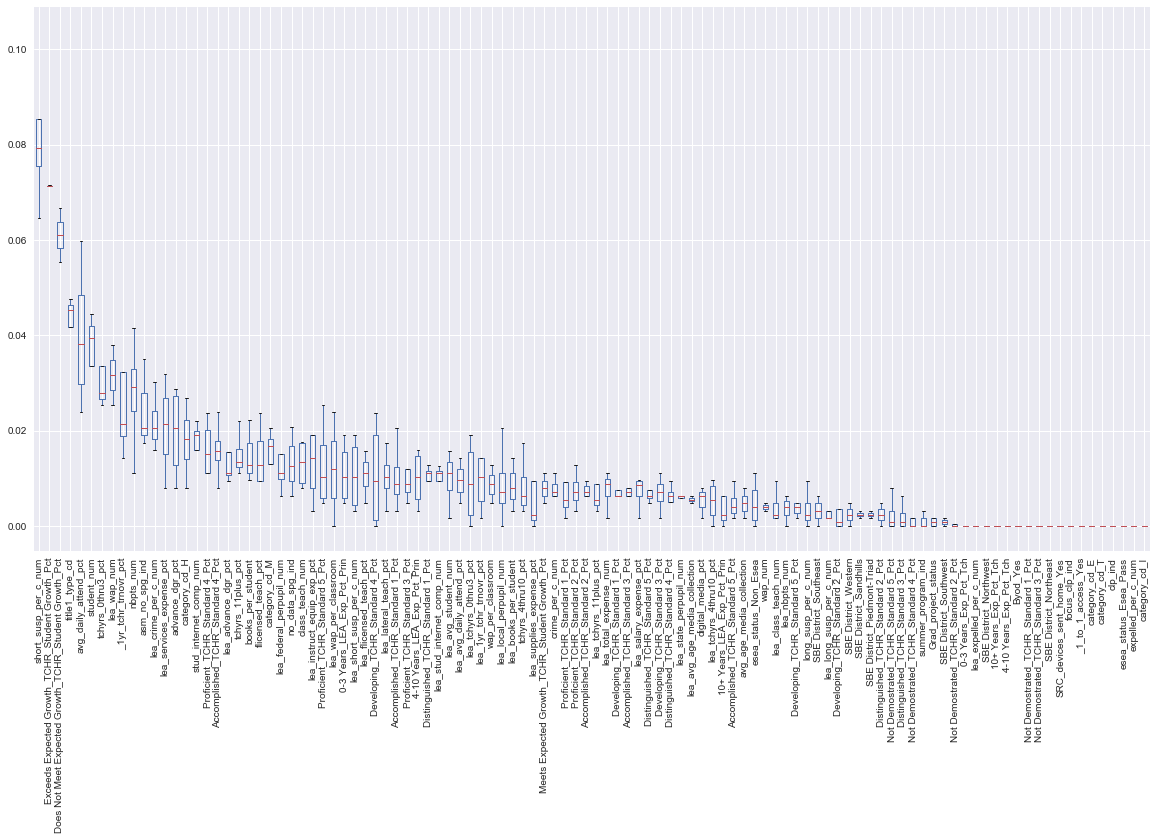

In [9]:
%matplotlib inline
all_importances = get_importances()
all_importances_plots = all_importances.sort_values('mean', ascending=False).T.drop(['mean','std'], axis=0)
all_importances_plots.boxplot(figsize=(20,10), rot=90)

In [10]:
all_importances_table = all_importances.sort_values('mean', ascending=False)
all_importances_table[0:10]

,df_14_featimp,df_15_featimp,df_16_featimp,df_17_featimp,mean,std
short_susp_per_c_num,0.064567,0.103668,0.079365,0.079239,0.081710,0.014033
Exceeds Expected Growth_TCHR_Student Growth_Pct,NaN,NaN,0.071429,0.071315,0.071372,0.000057
Does Not Meet Expected Growth_TCHR_Student Growth_Pct,NaN,NaN,0.066667,0.055468,0.061067,0.005600
title1_type_cd,0.033071,0.044657,0.047619,0.045959,0.042826,0.005729
avg_daily_attend_pct,0.059843,0.044657,0.023810,0.031696,0.040001,0.013661
student_num,0.037795,0.020734,0.044444,0.041204,0.036044,0.009147
tchyrs_0thru3_pct,0.048819,0.027113,0.025397,0.028526,0.032464,0.009507
lea_wap_num,NaN,NaN,0.025397,0.038035,0.031716,0.006319
_1yr_tchr_trnovr_pct,0.020472,0.062201,0.022222,0.014263,0.029790,0.018945
nbpts_num,0.028346,0.041467,0.030159,0.011094,0.027766,0.010860


## Top Ten Features by Importance
1. short_susp_per_c_num : Short term suspensions per 100 students at school level 
2. Exceeds Expected Growth_TCHR_Student Growth_Pct	
3. Does Not Meet Expected Growth_TCHR_Student Growth_Pct
4. title1_type_cd : title 1 status - " Title I, Part A (Title I) of the Elementary and Secondary Education Act, as amended (ESEA) provides financial assistance to local educational agencies (LEAs) and schools with high numbers or high percentages of children from low-income families to help ensure that all children meet challenging state academic standards." 
5. avg_daily_attend_pct: Average daily attendance percentage at school level 
6. student_num : Number of students at school level (school size) 
7. tchrs_0thru3_pct : Percent of teachers with 0 - 3 years of experience
8. lea_wap_num : Wireless Access Point
9. 1yr_tchr_trnover_pct : One Year Teacher turnover percentage at school level 
10. nbpts_num : Number of National Board Certified Staff at school level 

### Environment Variables Only


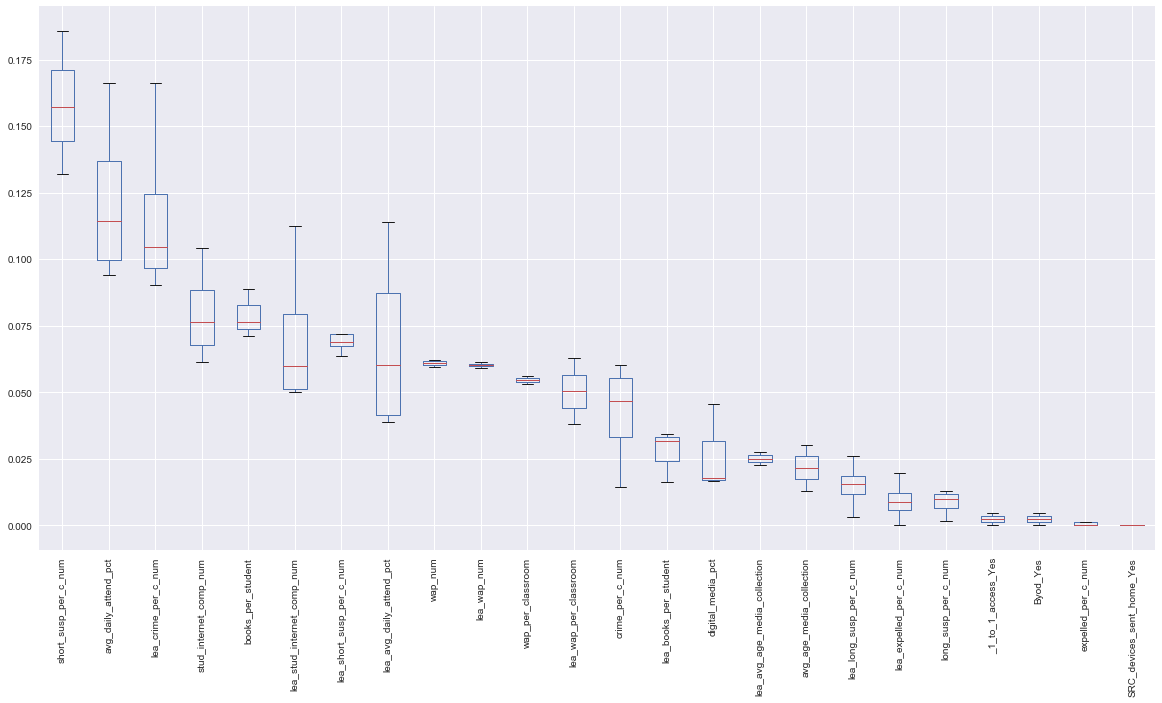

In [11]:
environmentCols.append("LPS")
environment_importances = get_importances(varset=environmentCols)
environment_importances_plots = environment_importances.sort_values('mean', ascending=False).T.drop(['mean','std'], axis=0)
environment_importances_plots.boxplot(figsize=(20,10), rot=90)

In [12]:
environment_importances_table = environment_importances.sort_values('mean', ascending=False)
environment_importances_table[0:10]

,df_14_featimp,df_15_featimp,df_16_featimp,df_17_featimp,mean,std
short_susp_per_c_num,0.166124,0.185668,0.148387,0.132018,0.158049,0.019993
avg_daily_attend_pct,0.166124,0.127036,0.101613,0.094082,0.122214,0.028139
lea_crime_per_c_num,0.166124,0.110749,0.090323,0.098634,0.116457,0.029581
stud_internet_comp_num,0.104235,0.083062,0.061290,0.069803,0.079597,0.016202
books_per_student,NaN,0.076547,0.088710,0.071320,0.078859,0.007285
lea_stud_internet_comp_num,0.112378,0.068404,0.051613,0.050076,0.070618,0.025159
lea_short_susp_per_c_num,0.068404,0.079805,0.069355,0.063733,0.070324,0.005873
lea_avg_daily_attend_pct,0.114007,0.078176,0.038710,0.042489,0.068345,0.030530
wap_num,NaN,NaN,0.059677,0.062215,0.060946,0.001269
lea_wap_num,NaN,NaN,0.061290,0.059181,0.060235,0.001055


## Top Ten Environmental Features by Importance
1. short_susp_per_c_num : Short term suspensions per 100 students at school level 
2. avg_daily_attend_pct : Average daily attendance percentage at school level 
3. lea_crime_per_c_num : Number of crimes or acts of violence per 100 students at LEA level
4. stud_internet_comp_num : Ratio of students to internet connected computer at school level 
5. books_per_student : Ratio of books to student at school level 
6. lea_stud_internet_comp_num : Ratio of students to internet connected computer at LEA level 
7. lea_short_susp_per_c_num : Short term suspensions per 100 students at LEA level 
8. lea_avg_daily_attend_pct : Average daily attendance percentage at LEA level 
9. wap_num : Wireless Access Points per Classroom at the school level
10. lea_wap_num : Wireless Access Points per Classroom at the LEA level

### Funding Variables Only

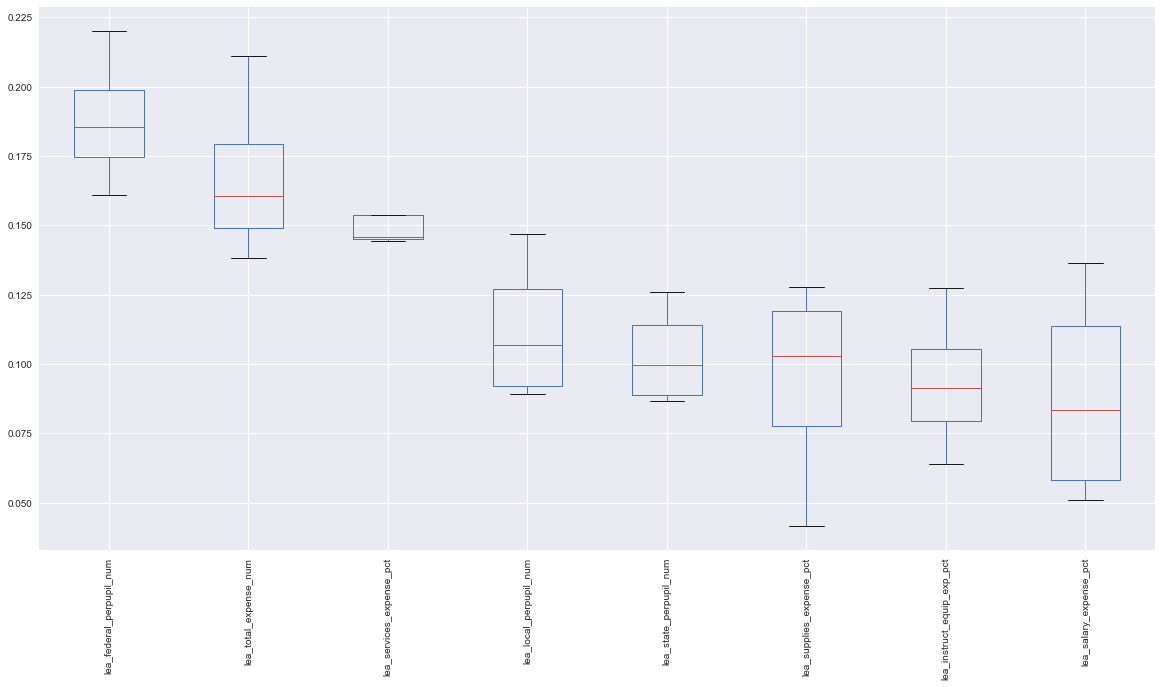

In [13]:
fundingCols.append("LPS")
funding_importances = get_importances(varset=fundingCols)
funding_importances_plots = funding_importances.sort_values('mean', ascending=False).T.drop(['mean','std'], axis=0)
funding_importances_plots.boxplot(figsize=(20,10), rot=90)

In [14]:
funding_importances_table = funding_importances.sort_values('mean', ascending=False)
funding_importances_table[0:10]

,df_14_featimp,df_15_featimp,df_16_featimp,df_17_featimp,mean,std
lea_federal_perpupil_num,0.191710,0.219904,0.160828,0.179402,0.187961,0.021470
lea_total_expense_num,0.138169,0.152488,0.168790,0.210963,0.167603,0.027278
lea_services_expense_pct,0.145078,0.144462,0.176752,0.146179,0.153118,0.013659
lea_local_perpupil_num,0.146805,0.120385,0.089172,0.093023,0.112346,0.023251
lea_state_perpupil_num,0.126079,0.086677,0.109873,0.089701,0.103083,0.015993
lea_supplies_expense_pct,0.127807,0.041734,0.116242,0.089701,0.093871,0.033120
lea_instruct_equip_exp_pct,0.063903,0.097913,0.127389,0.084718,0.093481,0.023027
lea_salary_expense_pct,0.060449,0.136437,0.050955,0.106312,0.088538,0.034683


### Important Funding Variables

1. LEA_federal_perpupil_num : Federal expense per pupil at LEA level 
2. lea_total_expense_num : Total expense (Dollars Spent) at school level
3. lea_services_expense_pct : Percent of expense spent on Services at LEA level

### Educator Variables Only

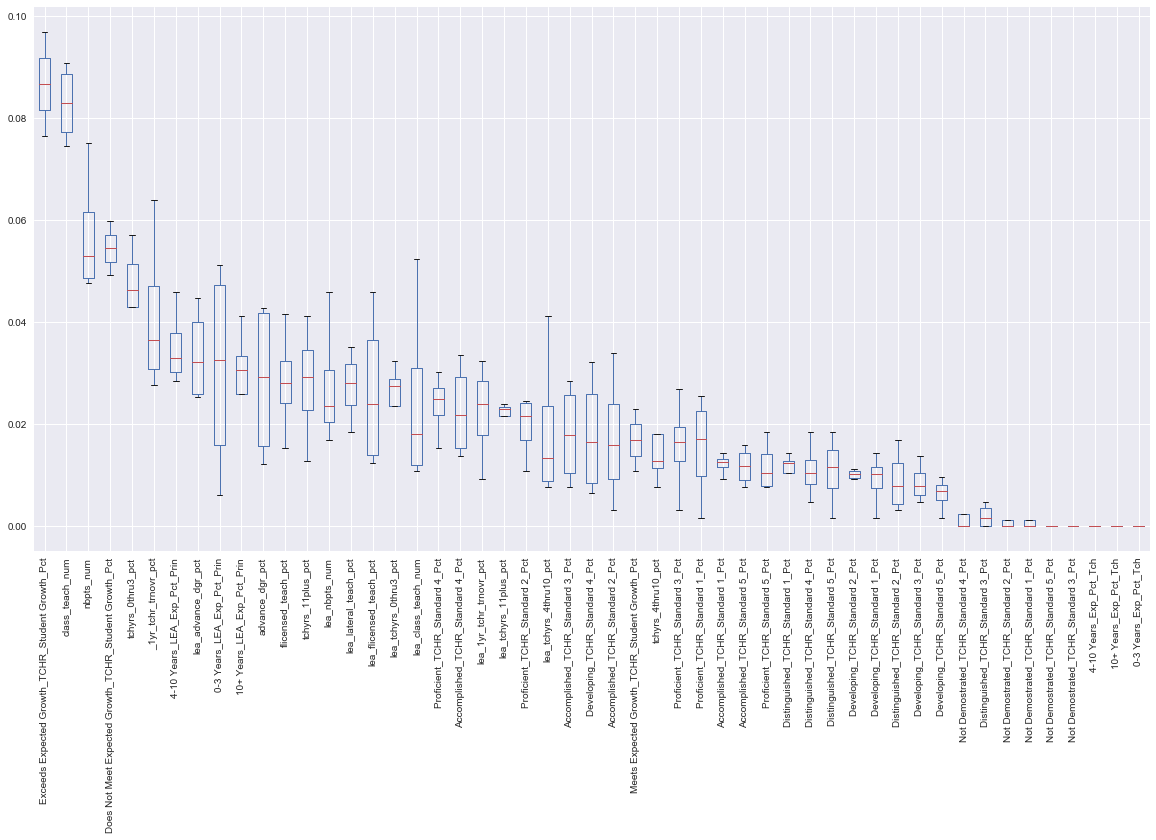

In [15]:
educatorCols.append("LPS")
educator_importances = get_importances(varset=educatorCols)
educator_importances_plots = educator_importances.sort_values('mean', ascending=False).T.drop(['mean','std'], axis=0)
educator_importances_plots.boxplot(figsize=(20,10), rot=90)

In [16]:
educator_importances_table = educator_importances.sort_values('mean', ascending=False)
educator_importances_table[0:10]

,df_14_featimp,df_15_featimp,df_16_featimp,df_17_featimp,mean,std
Exceeds Expected Growth_TCHR_Student Growth_Pct,NaN,NaN,0.076570,0.096923,0.086746,0.010177
class_teach_num,0.074485,0.087859,0.078101,0.090769,0.082804,0.006714
nbpts_num,0.057052,0.075080,0.049005,0.047692,0.057207,0.010923
Does Not Meet Expected Growth_TCHR_Student Growth_Pct,NaN,NaN,0.059724,0.049231,0.054478,0.005247
tchyrs_0thru3_pct,0.057052,0.049521,0.042879,0.043077,0.048132,0.005802
_1yr_tchr_trnovr_pct,0.031696,0.063898,0.041348,0.027692,0.041158,0.014036
4-10 Years_LEA_Exp_Pct_Prin,0.028526,0.035144,0.045942,0.030769,0.035095,0.006699
lea_advance_dgr_pct,0.025357,0.044728,0.026034,0.038462,0.033645,0.008256
0-3 Years_LEA_Exp_Pct_Prin,0.019017,0.051118,0.045942,0.006154,0.030558,0.018629
10+ Years_LEA_Exp_Pct_Prin,0.041204,0.030351,0.012251,0.030769,0.028644,0.010415


## Top Ten Educator Features by Importance
1. Exceeds Expected Growth_TCHR_Student Growth_Pct : Percentage of teachers exceeding student growth target
2. class_teach_num : Number of classroom teachers
3. nbpts_num : Number of National Board Certified teachers 
4. Does Not Meet Expected Growth_TCHR_Student Growth_Pct : Percentage of teachers not meeting student growth target
5. tchyrs_0thru3_pct : Perent of teachers with 0-3 years of experience at the school level
6. 1yr_tchr_trnovr_pct : One Year Teacher turnover percentage at school level 
7. 4-10 Years_LEA_Exp_Pct_Prin : Percent of principals with 4-10 years of experience at the LEA level
8. lea_advance_dgr_pct : Average percent of teachers with masters or higher degree at LEA level
9. 0-3 Years_LEA_Exp_Pct_Prin : Percent of principals with 0-3 years of experience at the LEA level
10. 10+ Years_LEA_Exp_Pct_Prin : Percent of principals with 10+ years of experience at the LEA level

### School Profile Variables Only

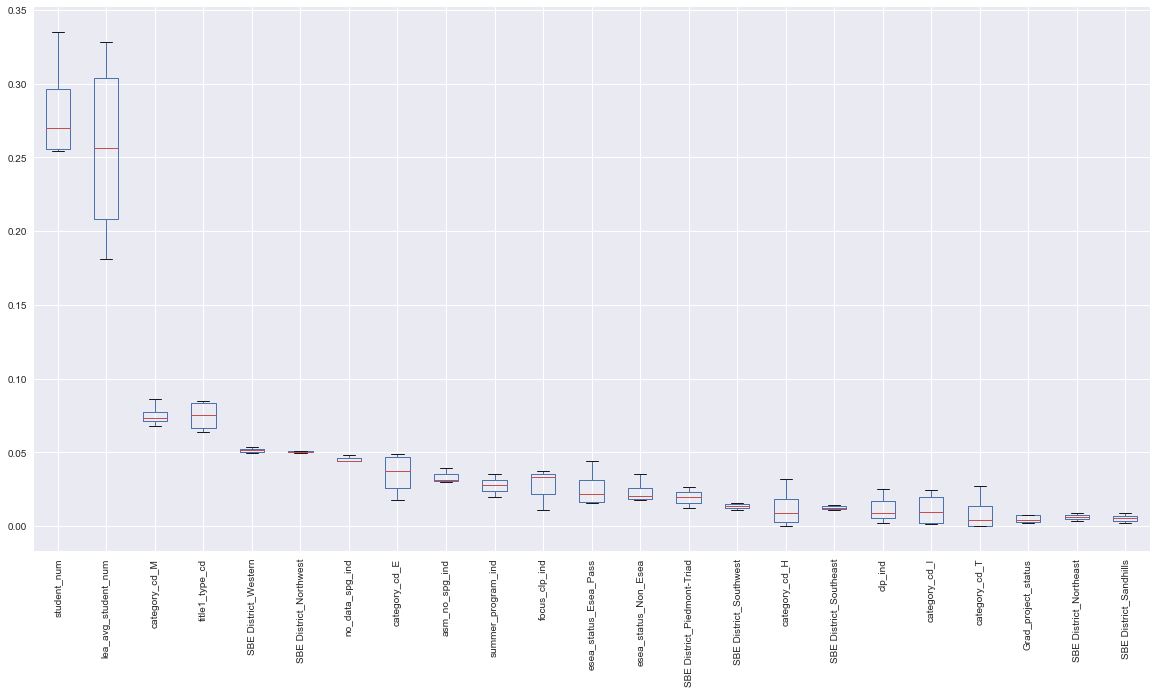

In [17]:
profileCols.append("LPS")
profile_importances = get_importances(varset=profileCols)
profile_importances_plots = profile_importances.sort_values('mean', ascending=False).T.drop(['mean','std'], axis=0)
profile_importances_plots.boxplot(figsize=(20,10), rot=90)

In [18]:
profile_importances_table = profile_importances.sort_values('mean', ascending=False)
profile_importances_table[0:10]

,df_14_featimp,df_15_featimp,df_16_featimp,df_17_featimp,mean,std
student_num,0.335025,0.253996,0.283088,0.256184,0.282073,0.032648
lea_avg_student_num,0.328257,0.181172,0.295956,0.217314,0.255675,0.058976
category_cd_M,0.086294,0.074600,0.068015,0.072438,0.075337,0.006757
title1_type_cd,0.084602,0.067496,0.082721,0.063604,0.074606,0.009184
SBE District_Western,NaN,0.053286,NaN,0.049470,0.051378,0.001908
SBE District_Northwest,NaN,0.049734,NaN,0.051237,0.050485,0.000752
no_data_spg_ind,NaN,0.047957,0.044118,0.044170,0.045415,0.001798
category_cd_E,0.049069,0.028419,0.045956,0.017668,0.035278,0.012859
asm_no_spg_ind,NaN,0.039076,0.031250,0.030035,0.033454,0.004006
summer_program_ind,NaN,0.019538,0.027574,0.035336,0.027482,0.006450


### Important School Profile Variables

1. student_num: Number of students at school level (school size) 
2. lea_avg_student_num: Average school size within the LEA 

# Top Features of Importance for LPS Prediction that Can Be Influenced

### School and Environment Level 
#### Resources
- wap_num : Wireless Access Points per Classroom at the school level
- lea_wap_num : Wireless Access Points per Classroom at the LEA level

- stud_internet_comp_num : Ratio of students to internet connected computer at school level 
- lea_stud_internet_comp_num : Ratio of students to internet connected computer at LEA level 

- books_per_student : Ratio of books to student at school level 

- student_num : Number of students at school level (school size) 
- lea_avg_student_num: Average school size within the LEA 

#### Discipline
-  short_susp_per_c_num : Short term suspensions per 100 students at school level 
-  lea_short_susp_per_c_num : Short term suspensions per 100 students at LEA level

-  avg_daily_attend_pct: Average daily attendance percentage at school level 
-  lea_avg_daily_attend_pct : Average daily attendance percentage at LEA level 

- lea_crime_per_c_num : Number of crimes or acts of violence per 100 students at LEA level


### Educator Level
#### Teachers
- class_teach_num : Number of classroom teachers
- tchrs_0thru3_pct : Percent of teachers with 0 - 3 years of experience
- 1yr_tchr_trnover_pct : One Year Teacher turnover percentage at school level 
- nbpts_num : Number of National Board Certified Staff at school level 
- lea_advance_dgr_pct : Average percent of teachers with masters or higher degree at LEA level
- Exceeds Expected Growth_TCHR_Student Growth_Pct : Percentage of teachers exceeding student growth target
- Does Not Meet Expected Growth_TCHR_Student Growth_Pct : Percentage of teachers not meeting student growth target

#### Principals
- 0-3 Years_LEA_Exp_Pct_Prin : Percent of principals with 0-3 years of experience at the LEA level
- 4-10 Years_LEA_Exp_Pct_Prin : Percent of principals with 4-10 years of experience at the LEA level
- 10+ Years_LEA_Exp_Pct_Prin : Percent of principals with 10+ years of experience at the LEA level

# Feature Importance for EVAAS Growth Score Using XGBoost

In [19]:
## Re-Read in Schools Dataset
df_14 = pd.read_csv(cwd+'/2014/PublicSchools2014_LPS_Processed.csv')
df_15 = pd.read_csv(cwd+'/2015/PublicSchools2015_LPS_Processed.csv')
df_16 = pd.read_csv(cwd+'/2016/PublicSchools2016_LPS_Processed.csv')
df_17 = pd.read_csv(cwd+'/2017/PublicSchools2017_LPS_Processed.csv')

In [20]:
## Delete some variables that are problematic for EVAAS Growth Score predictions: 
df_15 = df_15.drop(['no_data_spg_ind', 'asm_no_spg_ind'], axis =1)
df_16 = df_16.drop(['no_data_spg_ind', 'asm_no_spg_ind', 'Exceeds Expected Growth_TCHR_Student Growth_Pct',
                   'Does Not Meet Expected Growth_TCHR_Student Growth_Pct', 'Meets Expected Growth_TCHR_Student Growth_Pct'], axis =1)
df_17 = df_17.drop(['no_data_spg_ind','asm_no_spg_ind', 'Exceeds Expected Growth_TCHR_Student Growth_Pct',
                   'Does Not Meet Expected Growth_TCHR_Student Growth_Pct', 'Meets Expected Growth_TCHR_Student Growth_Pct'], axis =1)


In [21]:
# Full list of columns, including Personnel, Environment, and Teacher Experience Variables
environmentCols.remove('LPS')
fundingCols.remove('LPS')
educatorCols.remove('LPS')
profileCols.remove('LPS')
combined_cols = (environmentCols + fundingCols + educatorCols + profileCols)
combined_cols.append('EVAAS Growth Score')

In [22]:
# Subsets each dataframe based on the columns it shares with the 
# three sets of variables found in "combined_cols" (environment, personnel, and yoe)
df_17 = df_17[df_17.columns.intersection(combined_cols)]
df_16 = df_16[df_16.columns.intersection(combined_cols)]
df_15 = df_15[df_15.columns.intersection(combined_cols)]
df_14 = df_14[df_14.columns.intersection(combined_cols)]


# Storing dfs in list for later iteration
all_datasets = [df_14, df_15, df_16, df_17]

In [23]:
def xg_booster_seat(df, varset='all'):
    '''Performs xgboost on given set of variables, 
        returns feature importances'''
    
    # Subsetting variables if necessary
    if varset == 'all':
        df = df
    else:
        df = df[df.columns.intersection(varset)]
    
    # Predicting EVAAS Growth Score
    y = df['EVAAS Growth Score']
    x = df.drop('EVAAS Growth Score', axis=1)
        
    # Fitting the model
    model = XGBRegressor(nthread=4)
    model.fit(x, y)
   
    # Storing feature importances in dataframe
    feat_importances = pd.DataFrame(model.feature_importances_, index=x.columns)
    
    return feat_importances

col_names = ["df_14_featimp", 
            "df_15_featimp", 
            "df_16_featimp", 
            "df_17_featimp"]

def get_importances(col_names=col_names, varset='all'):
    
    importances = pd.DataFrame()
    for df in all_datasets:
        temp = xg_booster_seat(df, varset=varset)
        importances = pd.concat([importances, temp], axis=1)
    
    importances.columns = col_names
    importances['mean'] = importances.mean(axis=1)
    importances['std'] = importances.std(axis=1)
    
    return importances

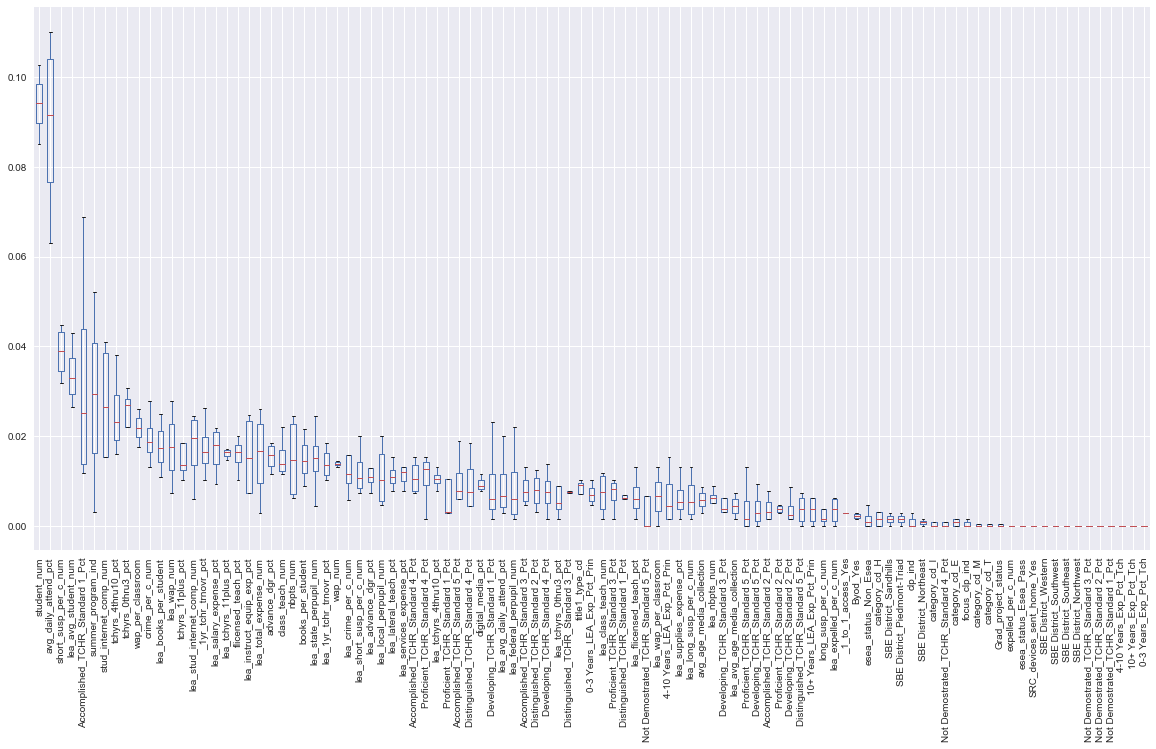

In [24]:
all_importances = get_importances()
all_importances_plots = all_importances.sort_values('mean', ascending=False).T.drop(['mean','std'], axis=0)
all_importances_plots.boxplot(figsize=(20,10), rot=90)

In [25]:
all_importances_table = all_importances.sort_values('mean', ascending=False)
all_importances_table[0:10]

,df_14_featimp,df_15_featimp,df_16_featimp,df_17_featimp,mean,std
student_num,0.102603,0.091190,0.085044,0.097101,0.093985,0.006553
avg_daily_attend_pct,0.081164,0.102009,0.063050,0.110145,0.089092,0.018379
short_susp_per_c_num,0.035222,0.044822,0.042522,0.031884,0.038613,0.005259
lea_avg_student_num,0.042879,0.035549,0.026393,0.030435,0.033814,0.006158
Accomplished_TCHR_Standard 1_Pct,0.068913,0.035549,0.011730,0.014493,0.032671,0.022862
summer_program_ind,NaN,0.003091,0.029326,0.052174,0.028197,0.020054
stud_internet_comp_num,0.015314,0.015456,0.041056,0.037681,0.027377,0.012051
tchyrs_4thru10_pct,0.026034,0.020093,0.038123,0.015942,0.025048,0.008358
tchyrs_0thru3_pct,0.009188,0.026275,0.030792,0.027536,0.023448,0.008396
wap_per_classroom,NaN,NaN,0.017595,0.026087,0.021841,0.004246



## Top Ten Features by Importance

1. student_num
2. avg_daily_attend_pct
3. short_susp_per_c_num
4. lea_avg_student_num
5. Accomplished_TCHR_Standard 1_Pct : Percent of Teachers reaching standard 1 : Teachers Demonstrate Leadership
6. summer_program_ind : Summer school program was included in Read to Achieve results
7. stud_internet_comp_num
8. tchyrs_4thru10_pct
9. tchyrs_0thru3_pct
10. wap_per_classroom 

https://stateboard.ncpublicschools.gov/policy-manual/evaluations-qualifications/evaluation-standards-and-criteria-teachers

## Environment Variables Only

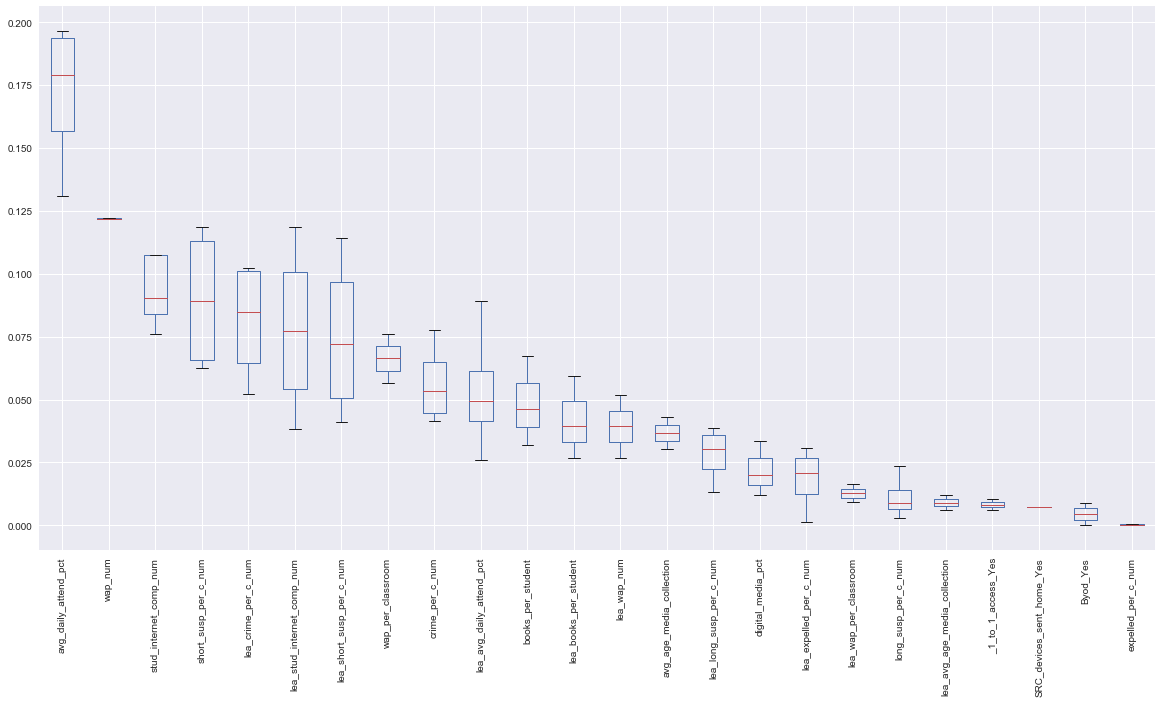

In [26]:
environmentCols.append("EVAAS Growth Score")
environment_importances = get_importances(varset=environmentCols)
environment_importances_plots = environment_importances.sort_values('mean', ascending=False).T.drop(['mean','std'], axis=0)
environment_importances_plots.boxplot(figsize=(20,10), rot=90)

In [27]:
environment_importances_table = environment_importances.sort_values('mean', ascending=False)
environment_importances_table[0:10]

,df_14_featimp,df_15_featimp,df_16_featimp,df_17_featimp,mean,std
avg_daily_attend_pct,0.192878,0.196481,0.131098,0.165179,0.171409,0.026236
wap_num,NaN,NaN,0.121951,0.122024,0.121988,0.000036
stud_internet_comp_num,0.148368,0.093842,0.086890,0.075893,0.101248,0.027947
short_susp_per_c_num,0.111276,0.118768,0.062500,0.066964,0.089877,0.025333
lea_crime_per_c_num,0.100890,0.068915,0.102134,0.052083,0.081006,0.021357
lea_stud_internet_comp_num,0.094955,0.118768,0.038110,0.059524,0.077839,0.031153
lea_short_susp_per_c_num,0.114243,0.090909,0.041159,0.053571,0.074971,0.029144
wap_per_classroom,NaN,NaN,0.076220,0.056548,0.066384,0.009836
crime_per_c_num,0.060831,0.077713,0.045732,0.041667,0.056485,0.014184
lea_avg_daily_attend_pct,0.089021,0.046921,0.025915,0.052083,0.053485,0.022737



## Top Ten Environment Features by Importance

1. avg_daily_attend_pct
2. wap_num
3. stud_internet_comp_num
4. short_susp_per_c_num
5. lea_crime_per_c_num
6. lea_stud_internet_comp_num
7. lea_short_susp_per_c_num
8. wap_per_classroom
9. crime_per_c_num
10. lea_avg_daily_attend_pct

## Educator Variables Only


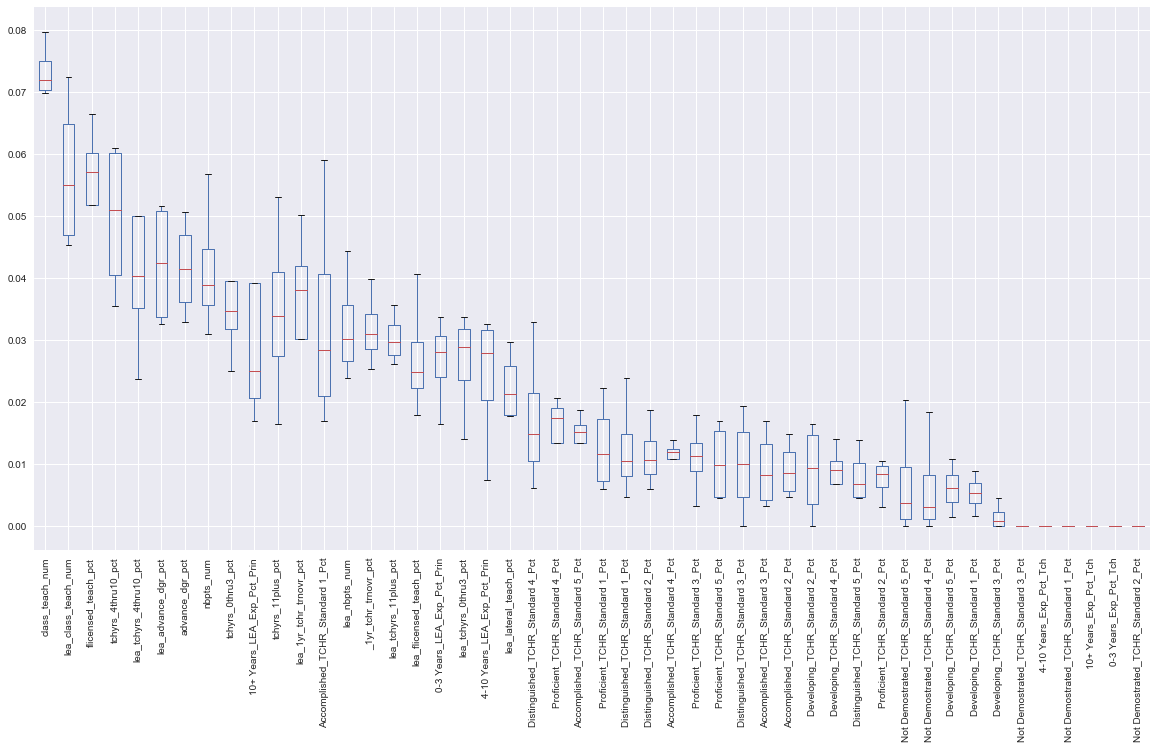

In [28]:
educatorCols.append("EVAAS Growth Score")
educator_importances = get_importances(varset=educatorCols)
educator_importances_plots = educator_importances.sort_values('mean', ascending=False).T.drop(['mean','std'], axis=0)
educator_importances_plots.boxplot(figsize=(20,10), rot=90)

In [29]:
educator_importances_table = educator_importances.sort_values('mean', ascending=False)
educator_importances_table[0:10]

,df_14_featimp,df_15_featimp,df_16_featimp,df_17_featimp,mean,std
class_teach_num,0.079764,0.073437,0.070552,0.069837,0.073397,0.003915
lea_class_teach_num,0.072378,0.045313,0.047546,0.062407,0.056911,0.011087
flicensed_teach_pct,0.066470,0.056250,0.038344,0.057949,0.054753,0.010235
tchyrs_4thru10_pct,0.035451,0.042188,0.059816,0.060921,0.049594,0.011042
lea_tchyrs_4thru10_pct,0.023634,0.039062,0.075153,0.041605,0.044864,0.018791
lea_advance_dgr_pct,0.032496,0.051562,0.050613,0.034175,0.042212,0.008902
advance_dgr_pct,0.045790,0.032812,0.050613,0.037147,0.041591,0.006997
nbpts_num,0.031019,0.040625,0.056748,0.037147,0.041385,0.009513
tchyrs_0thru3_pct,0.033973,0.025000,0.035276,0.052006,0.036564,0.009754
10+ Years_LEA_Exp_Pct_Prin,0.028065,0.021875,0.016871,0.072808,0.034905,0.022240



## Top Ten Educator Features by Importance

1. class_teach_num 
2. lea_class_teach_num
3. flicensed_teach_pct
4. tchyrs_4thru10_pct
5. lea_tchyrs_4thru10_pct
6. lea_advance_dgr_pct
7. advance_dgr_pct
8. nbpts_num
9. tchyrs_0thru3_pct
10. 10+ Years_LEA_Exp_Pct_Prin


# Top Features of Importance for EVAAS GROWTH SCORE Prediction that Can Be Influenced

### School and Environment Level 
#### Resources
- student_num

- class_teach_num
- lea_class_teach_num

- wap_num
- wap_per_classroom

- stud_internet_comp_num
- lea_stud_internet_comp_num

- summer_program_ind : Summer school program was included in Read to Achieve results


#### Discipline
- avg_daily_attend_pct
- lea_avg_daily_attend_pct

- short_susp_per_c_num
- lea_short_susp_per_c_num

- lea_crime_per_c_num
- crime_per_c_num

### Educator Level
#### Teachers
- flicensed_teach_pct
- nbpts_num

- tchyrs_0thru3_pct
- tchyrs_4thru10_pct
- lea_tchyrs_4thru10_pct

- advance_dgr_pct
- lea_advance_dgr_pct

- Accomplished_TCHR_Standard 1_Pct : Percent of Teachers reaching standard 1 : Teachers Demonstrate Leadership

#### Principals
- 10+ Years_LEA_Exp_Pct_Prin


## How Well Does the Model Perform?

In [30]:
y = df_17['EVAAS Growth Score']
x = df_17.drop('EVAAS Growth Score', axis=1)

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=7)

In [33]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

# fit model no training data
model = XGBRegressor(nthread=4)
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
explained_variance = explained_variance_score(y_test, predictions)
MAE = mean_absolute_error(y_test, predictions)
MSE = mean_squared_error(y_test, predictions)
rsq = r2_score(y_test, predictions)

print("Explained Variance: ", explained_variance)
print("MAE: ", MAE)
print("MSE: ", MSE)
print("R2: ", rsq)

Explained Variance:  0.490515942936
MAE:  10.5425357873
MSE:  241.341779141
R2:  0.490515391957


In [50]:
## Read in Schools Dataset
df_14 = pd.read_csv(cwd+'/2014/PublicSchools2014_LPS_Processed.csv')
df_15 = pd.read_csv(cwd+'/2015/PublicSchools2015_LPS_Processed.csv')
df_16 = pd.read_csv(cwd+'/2016/PublicSchools2016_LPS_Processed.csv')
df_17 = pd.read_csv(cwd+'/2017/PublicSchools2017_LPS_Processed.csv')

# Changing to LPS so it works with the xgboost functions
df_17 = df_17.rename(columns = {'LPS_17' : 'LPS'})

# Full list of columns, including Personnel, Environment, and Teacher Experience Variables
combined_cols = (environmentCols + fundingCols + educatorCols + profileCols)
combined_cols.append('LPS')
combined_cols.remove('EVAAS Growth Score')
combined_cols.remove('EVAAS Growth Score')

# Subsets each dataframe based on the columns it shares with the 
# three sets of variables found in "combined_cols" (environment, personnel, and yoe)
df_17 = df_17[df_17.columns.intersection(combined_cols)]
df_16 = df_16[df_16.columns.intersection(combined_cols)]
df_15 = df_15[df_15.columns.intersection(combined_cols)]
df_14 = df_14[df_14.columns.intersection(combined_cols)]


# Storing dfs in list for later iteration
all_datasets = [df_14, df_15, df_16, df_17]

In [51]:
y = df_17['LPS']
x = df_17.drop('LPS', axis=1)

In [52]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=5)

In [53]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# fit model no training data
model = XGBClassifier(nthread=4)
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 Score:", f1)

Accuracy: 88.75%
F1 Score: 0.674556213018


## SPG Score

In [57]:
## Read in Schools Dataset
df_14 = pd.read_csv(cwd+'/2014/PublicSchools2014_LPS_Processed.csv')
df_15 = pd.read_csv(cwd+'/2015/PublicSchools2015_LPS_Processed.csv')
df_16 = pd.read_csv(cwd+'/2016/PublicSchools2016_LPS_Processed.csv')
df_17 = pd.read_csv(cwd+'/2017/PublicSchools2017_LPS_Processed.csv')

# Changing to LPS so it works with the xgboost functions
df_17 = df_17.rename(columns = {'LPS_17' : 'LPS'})

# Full list of columns, including Personnel, Environment, and Teacher Experience Variables
combined_cols = (environmentCols + fundingCols + educatorCols + profileCols)
combined_cols.append('SPG Score')
combined_cols.remove('EVAAS Growth Score')
combined_cols.remove('EVAAS Growth Score')

# Subsets each dataframe based on the columns it shares with the 
# three sets of variables found in "combined_cols" (environment, personnel, and yoe)
df_17 = df_17[df_17.columns.intersection(combined_cols)]
df_16 = df_16[df_16.columns.intersection(combined_cols)]
df_15 = df_15[df_15.columns.intersection(combined_cols)]
df_14 = df_14[df_14.columns.intersection(combined_cols)]


# Storing dfs in list for later iteration
all_datasets = [df_14, df_15, df_16, df_17]

In [58]:
y = df_17['SPG Score']
x = df_17.drop('SPG Score', axis=1)

In [59]:
list(x.columns)

['title1_type_cd',
 'clp_ind',
 'focus_clp_ind',
 'summer_program_ind',
 'asm_no_spg_ind',
 'no_data_spg_ind',
 'student_num',
 'lea_avg_student_num',
 'Grad_project_status',
 'lea_total_expense_num',
 'lea_salary_expense_pct',
 'lea_services_expense_pct',
 'lea_supplies_expense_pct',
 'lea_instruct_equip_exp_pct',
 'lea_federal_perpupil_num',
 'lea_local_perpupil_num',
 'lea_state_perpupil_num',
 'avg_daily_attend_pct',
 'crime_per_c_num',
 'short_susp_per_c_num',
 'long_susp_per_c_num',
 'expelled_per_c_num',
 'stud_internet_comp_num',
 'lea_avg_daily_attend_pct',
 'lea_crime_per_c_num',
 'lea_short_susp_per_c_num',
 'lea_long_susp_per_c_num',
 'lea_expelled_per_c_num',
 'lea_stud_internet_comp_num',
 'digital_media_pct',
 'avg_age_media_collection',
 'books_per_student',
 'lea_avg_age_media_collection',
 'lea_books_per_student',
 'wap_num',
 'wap_per_classroom',
 'lea_wap_num',
 'lea_wap_per_classroom',
 'flicensed_teach_pct',
 'tchyrs_0thru3_pct',
 'tchyrs_4thru10_pct',
 'tchyrs_11

In [60]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=5)

In [61]:
# fit model no training data
model = XGBRegressor(nthread=4)
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
explained_variance = explained_variance_score(y_test, predictions)
MAE = mean_absolute_error(y_test, predictions)
MSE = mean_squared_error(y_test, predictions)
rsq = r2_score(y_test, predictions)

print("Explained Variance: ", explained_variance)
print("MAE: ", MAE)
print("MSE: ", MSE)
print("R2: ", rsq)

Explained Variance:  0.868974746505
MAE:  5.65848670757
MSE:  50.2556237219
R2:  0.868971595414
